# Word statistic

In [173]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Import scripts

In [174]:
from schrutepy import schrutepy 

In [175]:
script_w = schrutepy.load_schrute()

In [176]:
def schrut_prep(df):
    df.drop(columns=['index'], axis=1, inplace=True)

    df.drop(df[df.text_w_direction.isna()].index, axis=0, inplace=True)
    
    df.rename(columns={'episode_name':'title','text_w_direction':'text_w'},inplace=True)
    
    return df

In [177]:
script_w = schrut_prep(script_w)

In [178]:
script = script_w.dropna()

In [179]:
script.head()

,season,episode,title,director,writer,character,text,text_w
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,All right Jim. Your quarterlies look very good...,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Jim,"Oh, I told you. I couldn't close it. So...","Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,So you've come to the master for guidance? Is ...,So you've come to the master for guidance? Is ...
3,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Jim,"Actually, you called me in here, but yeah.","Actually, you called me in here, but yeah."
4,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,"All right. Well, let me show you how it's done.","All right. Well, let me show you how it's done."


In [180]:
import nltk
from nltk.corpus import stopwords

stop_words = list(set(stopwords.words('english')))

# Import episode ifo

In [181]:
df = pd.read_csv('imdb.csv')

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   season    186 non-null    int64  
 1   title     186 non-null    object 
 2   rating    186 non-null    float64
 3   votes     186 non-null    int64  
 4   double    186 non-null    int64  
 5   episode   186 non-null    int64  
 6   month     186 non-null    int64  
 7   director  186 non-null    object 
 8   writer    186 non-null    object 
dtypes: float64(1), int64(5), object(3)
memory usage: 13.2+ KB


In [183]:
df.head()

,season,title,rating,votes,double,episode,month,director,writer
0,1,Pilot,7.4,7006,0,1,3,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels
1,1,Diversity Day,8.3,6902,0,2,3,Ken Kwapis,B.J. Novak
2,1,Health Care,7.7,5756,0,3,4,Ken Whittingham,Paul Lieberstein
3,1,The Alliance,8.0,5579,0,4,4,Bryan Gordon,Michael Schur
4,1,Basketball,8.4,6183,0,5,4,Greg Daniels,Greg Daniels


# Functions to work with text

In [184]:
def prepare_text(text, stop=True):
    words = nltk.word_tokenize(text)

    words=[word.lower() for word in words if word.isalpha()]
    
    if stop:
        words = [w for w in words if not w in stop_words]
    
    return words

In [185]:
def dispersion_plot(text, words, ignore_case=False, title="Lexical Dispersion Plot"):
    """
    Generate a lexical dispersion plot.

    :param text: The source text
    :type text: list(str) or enum(str)
    :param words: The target words
    :type words: list of str
    :param ignore_case: flag to set if case should be ignored when searching text
    :type ignore_case: bool
    
    https://www.nltk.org/_modules/nltk/draw/dispersion.html
    """

    try:
        from matplotlib import pylab
    except ImportError as e:
        raise ValueError(
            "The plot function requires matplotlib to be installed."
            "See https://matplotlib.org/"
        ) from e

    text = list(text)
    words.reverse()

    if ignore_case:
        words_to_comp = list(map(str.lower, words))
        text_to_comp = list(map(str.lower, text))
    else:
        words_to_comp = words
        text_to_comp = text

    points = [
        (x, y)
        for x in range(len(text_to_comp))
        for y in range(len(words_to_comp))
        if text_to_comp[x] == words_to_comp[y]
    ]
    if points:
        x, y = list(zip(*points))
    else:
        x = y = ()
    pylab.plot(x, y, "b|", scalex=0.1)
    pylab.yticks(list(range(len(words))), words, color="b")
    pylab.ylim(-1, len(words))
    pylab.title(title)
    pylab.xlabel("Word Offset")
    pylab.show()


# Count words in episode
without stopword cleaning

In [186]:
df['words'] = 0

for season in range(1,10):
    episodes = np.sort(df[df.season==season].episode.unique())

    for episode in episodes: 
        text_row = ' '.join( word for word in script[(script.season==season) & (script.episode==episode)].text)
        
        text = prepare_text(text_row,stop=False)
        
        df.loc[(df.season==season) & (df.episode==episode),'words'] = len(text)      
        

<AxesSubplot:xlabel='words', ylabel='Count'>

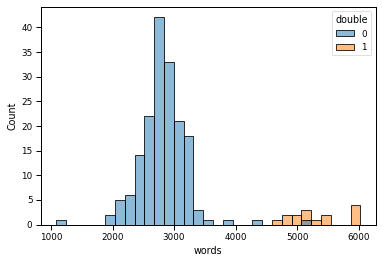

In [187]:
sns.histplot(data=df, x='words', hue='double')

In [188]:
df[(df.words > 5000) & (df.double==0)]

,season,title,rating,votes,double,episode,month,director,writer,words
178,9,Moving On,8.0,3065,0,16,2,Jon Favreau,Graham Wagner,5209


There is one more double series, mark it: 

In [189]:
df.loc[(df.season==9) & (df.episode==16),'double'] = 1

# Most popular words

In [190]:
text_row = ' '.join( word for word in script.text)
        
all_text_without_stop = prepare_text(text_row,stop=True)
most_common = nltk.FreqDist(text)
print(most_common.most_common(100))

[('i', 267), ('you', 214), ('the', 176), ('a', 133), ('it', 126), ('to', 122), ('and', 108), ('that', 98), ('is', 79), ('my', 70), ('for', 68), ('do', 64), ('this', 60), ('in', 58), ('oh', 58), ('just', 57), ('of', 55), ('what', 55), ('have', 52), ('we', 48), ('no', 47), ('so', 45), ('was', 44), ('me', 43), ('are', 42), ('but', 38), ('your', 36), ('know', 34), ('on', 33), ('all', 33), ('how', 33), ('did', 32), ('hey', 31), ('be', 30), ('yeah', 30), ('he', 29), ('here', 26), ('good', 25), ('well', 25), ('get', 25), ('okay', 24), ('like', 24), ('there', 24), ('they', 24), ('now', 24), ('at', 24), ('with', 24), ('na', 24), ('out', 22), ('not', 21), ('if', 21), ('go', 21), ('jim', 20), ('yes', 20), ('about', 20), ('been', 19), ('think', 18), ('can', 18), ('got', 18), ('from', 18), ('dwight', 17), ('one', 17), ('right', 17), ('see', 17), ('us', 17), ('thank', 16), ('really', 16), ('had', 16), ('say', 15), ('could', 15), ('uh', 15), ('come', 14), ('let', 14), ('only', 14), ('love', 14), ('wh

In [238]:
intresting_words = ['love','sad','paper','sales','wedding','christmas',
                    'party','birthday','dundies','dunder','office','sorry',
                    'money','leaving','safety','joke','baby','new','changes','meeting','drugs','pizza','santa']

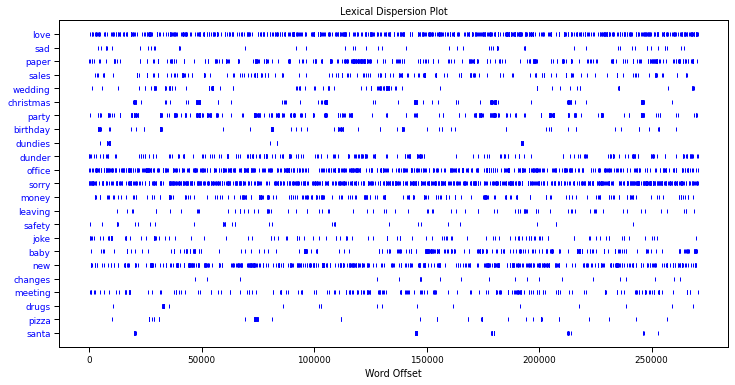

In [235]:
plt.figure(figsize=(12,6))
dispersion_plot(all_text_without_stop,intresting_words,ignore_case=True)

## count appearance of interesting word in each episode

In [239]:
for word in intresting_words:
    df[word] = np.nan
    
for season in range(1,10):
    episodes = np.sort(df[df.season==season].episode.unique())

    for episode in episodes: 
        text_row = ' '.join( word for word in script[(script.season==season) & (script.episode==episode)].text)

        text = prepare_text(text_row, stop=True)
        
        for word in intresting_words:
            df.loc[(df.season==season) & (df.episode==episode),word] = text.count(word)

In [245]:
sns.set_context('paper',font_scale=1)

df_tmp = df[np.insert(intresting_words,0,'rating')]
df_tmp.corr()['rating'].round(2).sort_values(ascending=False)

rating       1.00
leaving      0.22
wedding      0.18
dunder       0.17
love         0.16
safety       0.14
christmas    0.13
party        0.13
dundies      0.12
money        0.11
santa        0.08
new          0.08
joke         0.07
paper        0.07
office       0.06
sad          0.04
drugs        0.04
sorry        0.02
pizza       -0.01
birthday    -0.03
baby        -0.04
meeting     -0.06
changes     -0.07
sales       -0.07
Name: rating, dtype: float64

# Most popular words in each episode
with stopwords

In [247]:
additional_stop_words = ['oh','know','okay','like','yeah','go','want','well','going','hey','think','uh','get']

In [248]:
df['most_popular_words'] = np.nan

for season in range(1,10):
    episodes = np.sort(df[df.season==season].episode.unique())

    for episode in episodes: 
        text_row = ' '.join( word for word in script[(script.season==season) & (script.episode==episode)].text)
        
        text = prepare_text(text_row, stop=True)
        
        
        text_2 = [w for w in text if not w in additional_stop_words]
        
        most_common = nltk.FreqDist(text_2).most_common(1)
        
#         print(most_common[0][0])
        df.loc[(df.season==season) & (df.episode==episode),'most_popular_words'] = most_common[0][0]

In [249]:
df.most_popular_words.value_counts()

right        26
michael      24
na           12
good         12
dwight       12
one           9
ok            9
andy          6
really        5
would         5
christmas     4
got           4
pam           4
jim           3
new           2
dundies       2
birthday      2
stanley       2
baby          2
yes           2
stop          2
hot           2
deangelo      2
make          1
gym           1
franklin      1
back          1
pie           1
leads         1
prison        1
utica         1
people        1
santa         1
ed            1
hay           1
love          1
luke          1
idea          1
pum           1
ryan          1
pizza         1
phyllis       1
come          1
gabe          1
um            1
drugs         1
kelly         1
gay           1
lice          1
god           1
let           1
scarn         1
computron     1
sabre         1
kids          1
points        1
Name: most_popular_words, dtype: int64

# Count words in episode for each character
df['name_words'] = how much person says words (divided by two for double episode)

In [98]:
script.character.value_counts()[:20]

Michael     10877
Dwight       6801
Jim          6268
Pam          5006
Andy         3739
Angela       1551
Kevin        1551
Erin         1431
Oscar        1359
Ryan         1191
Darryl       1177
Phyllis       968
Kelly         835
Toby          813
Jan           807
Stanley       671
Meredith      558
Holly         554
Nellie        527
Gabe          427
Name: character, dtype: int64

In [140]:
characters = script.character.value_counts()[:20].index
characters

Index(['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Angela', 'Kevin', 'Erin',
       'Oscar', 'Ryan', 'Darryl', 'Phyllis', 'Kelly', 'Toby', 'Jan', 'Stanley',
       'Meredith', 'Holly', 'Nellie', 'Gabe'],
      dtype='object')

In [151]:
for person in characters:
    df[person + '_words'] = np.nan

    for season in range(1,10):
        episodes = np.sort(df[df.season==season].episode.unique())

        for episode in episodes: 
            text_row = ' '.join( word for word in script[(script.season==season) & (script.episode==episode) & (script.character==person)].text)
            
            # do not delete stop words
            text = prepare_text(text_row, stop=False)
            

#             # divide by two for double episode
#             coef = 1
#             if df[(df.season==season) & (df.episode==episode)].double.values == 1:
#                 coef = 2
    
#             df.loc[(df.season==season) & (df.episode==episode),[person + '_words']] = len(text)/coef
        
            total_words = df[(df.season==season) & (df.episode==episode)].words
            df.loc[(df.season==season) & (df.episode==episode),[person + '_words']] = 100*len(text)/total_words

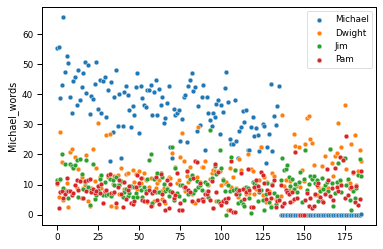

In [152]:
legend=[]
for person in characters[:4]:
    sns.scatterplot(y=df[person + '_words'], x=df.index)
    legend.append(person)
    
plt.legend(legend)

<AxesSubplot:>

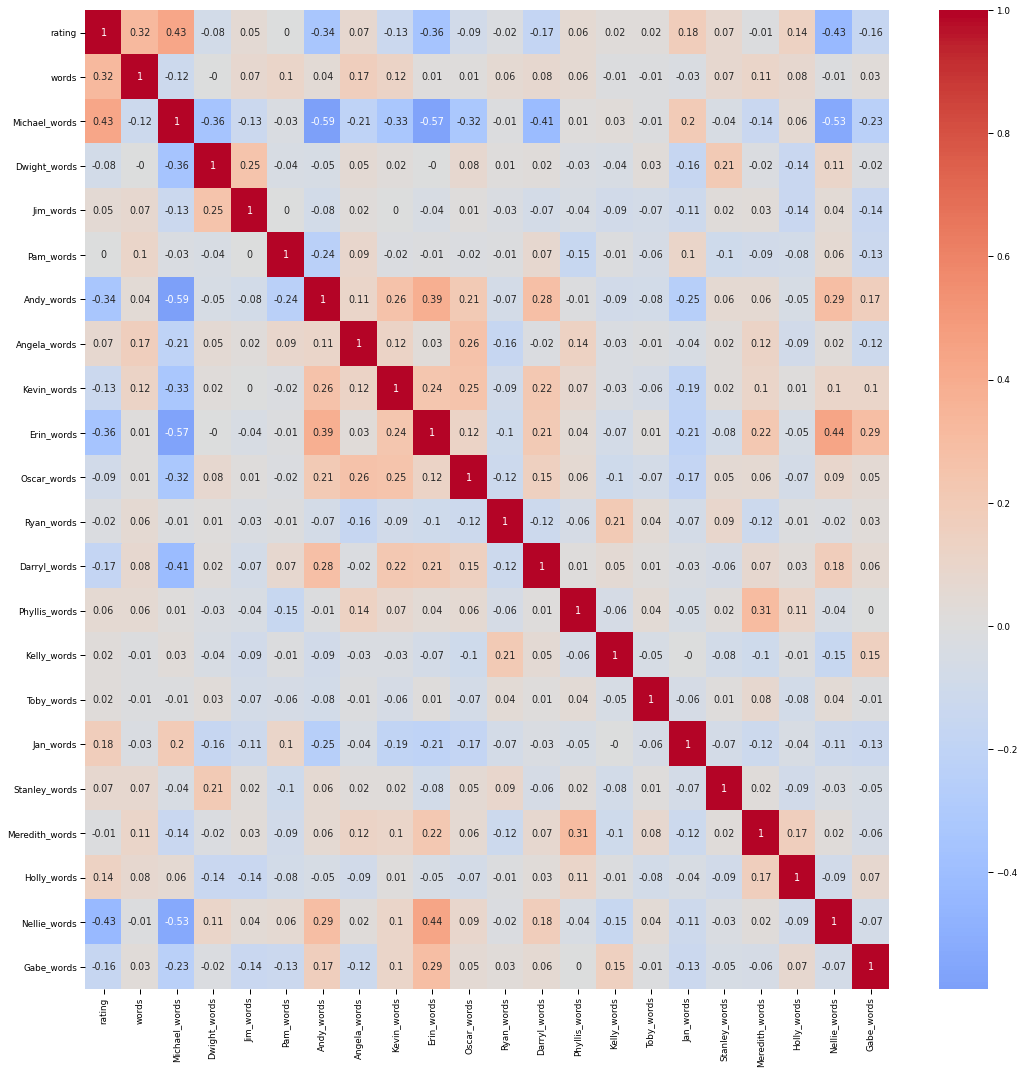

In [153]:
sns.set_context('paper',font_scale=1)
corr = df.drop(columns=['season','title','votes','double','episode','month','director','writer'], axis=1).corr().round(2)

# mask = np.triu(np.ones_like(, dtype=bool))

plt.figure(figsize=(18,18))
sns.heatmap(corr, cmap='coolwarm', center=0,annot=True)

rating has stron correlatio with:   
words    
Michael 
Holly
Andy, Kevin, Arin, Darryl (all of them have negative correlation with Michael)   
Jan (has positive correltion with Michael)



monolog type connections:   
Michael - almost everybody (except Jan)   

dialog type:   
Michael-Jan    
Dwight - Jim
Dwight - Stanley


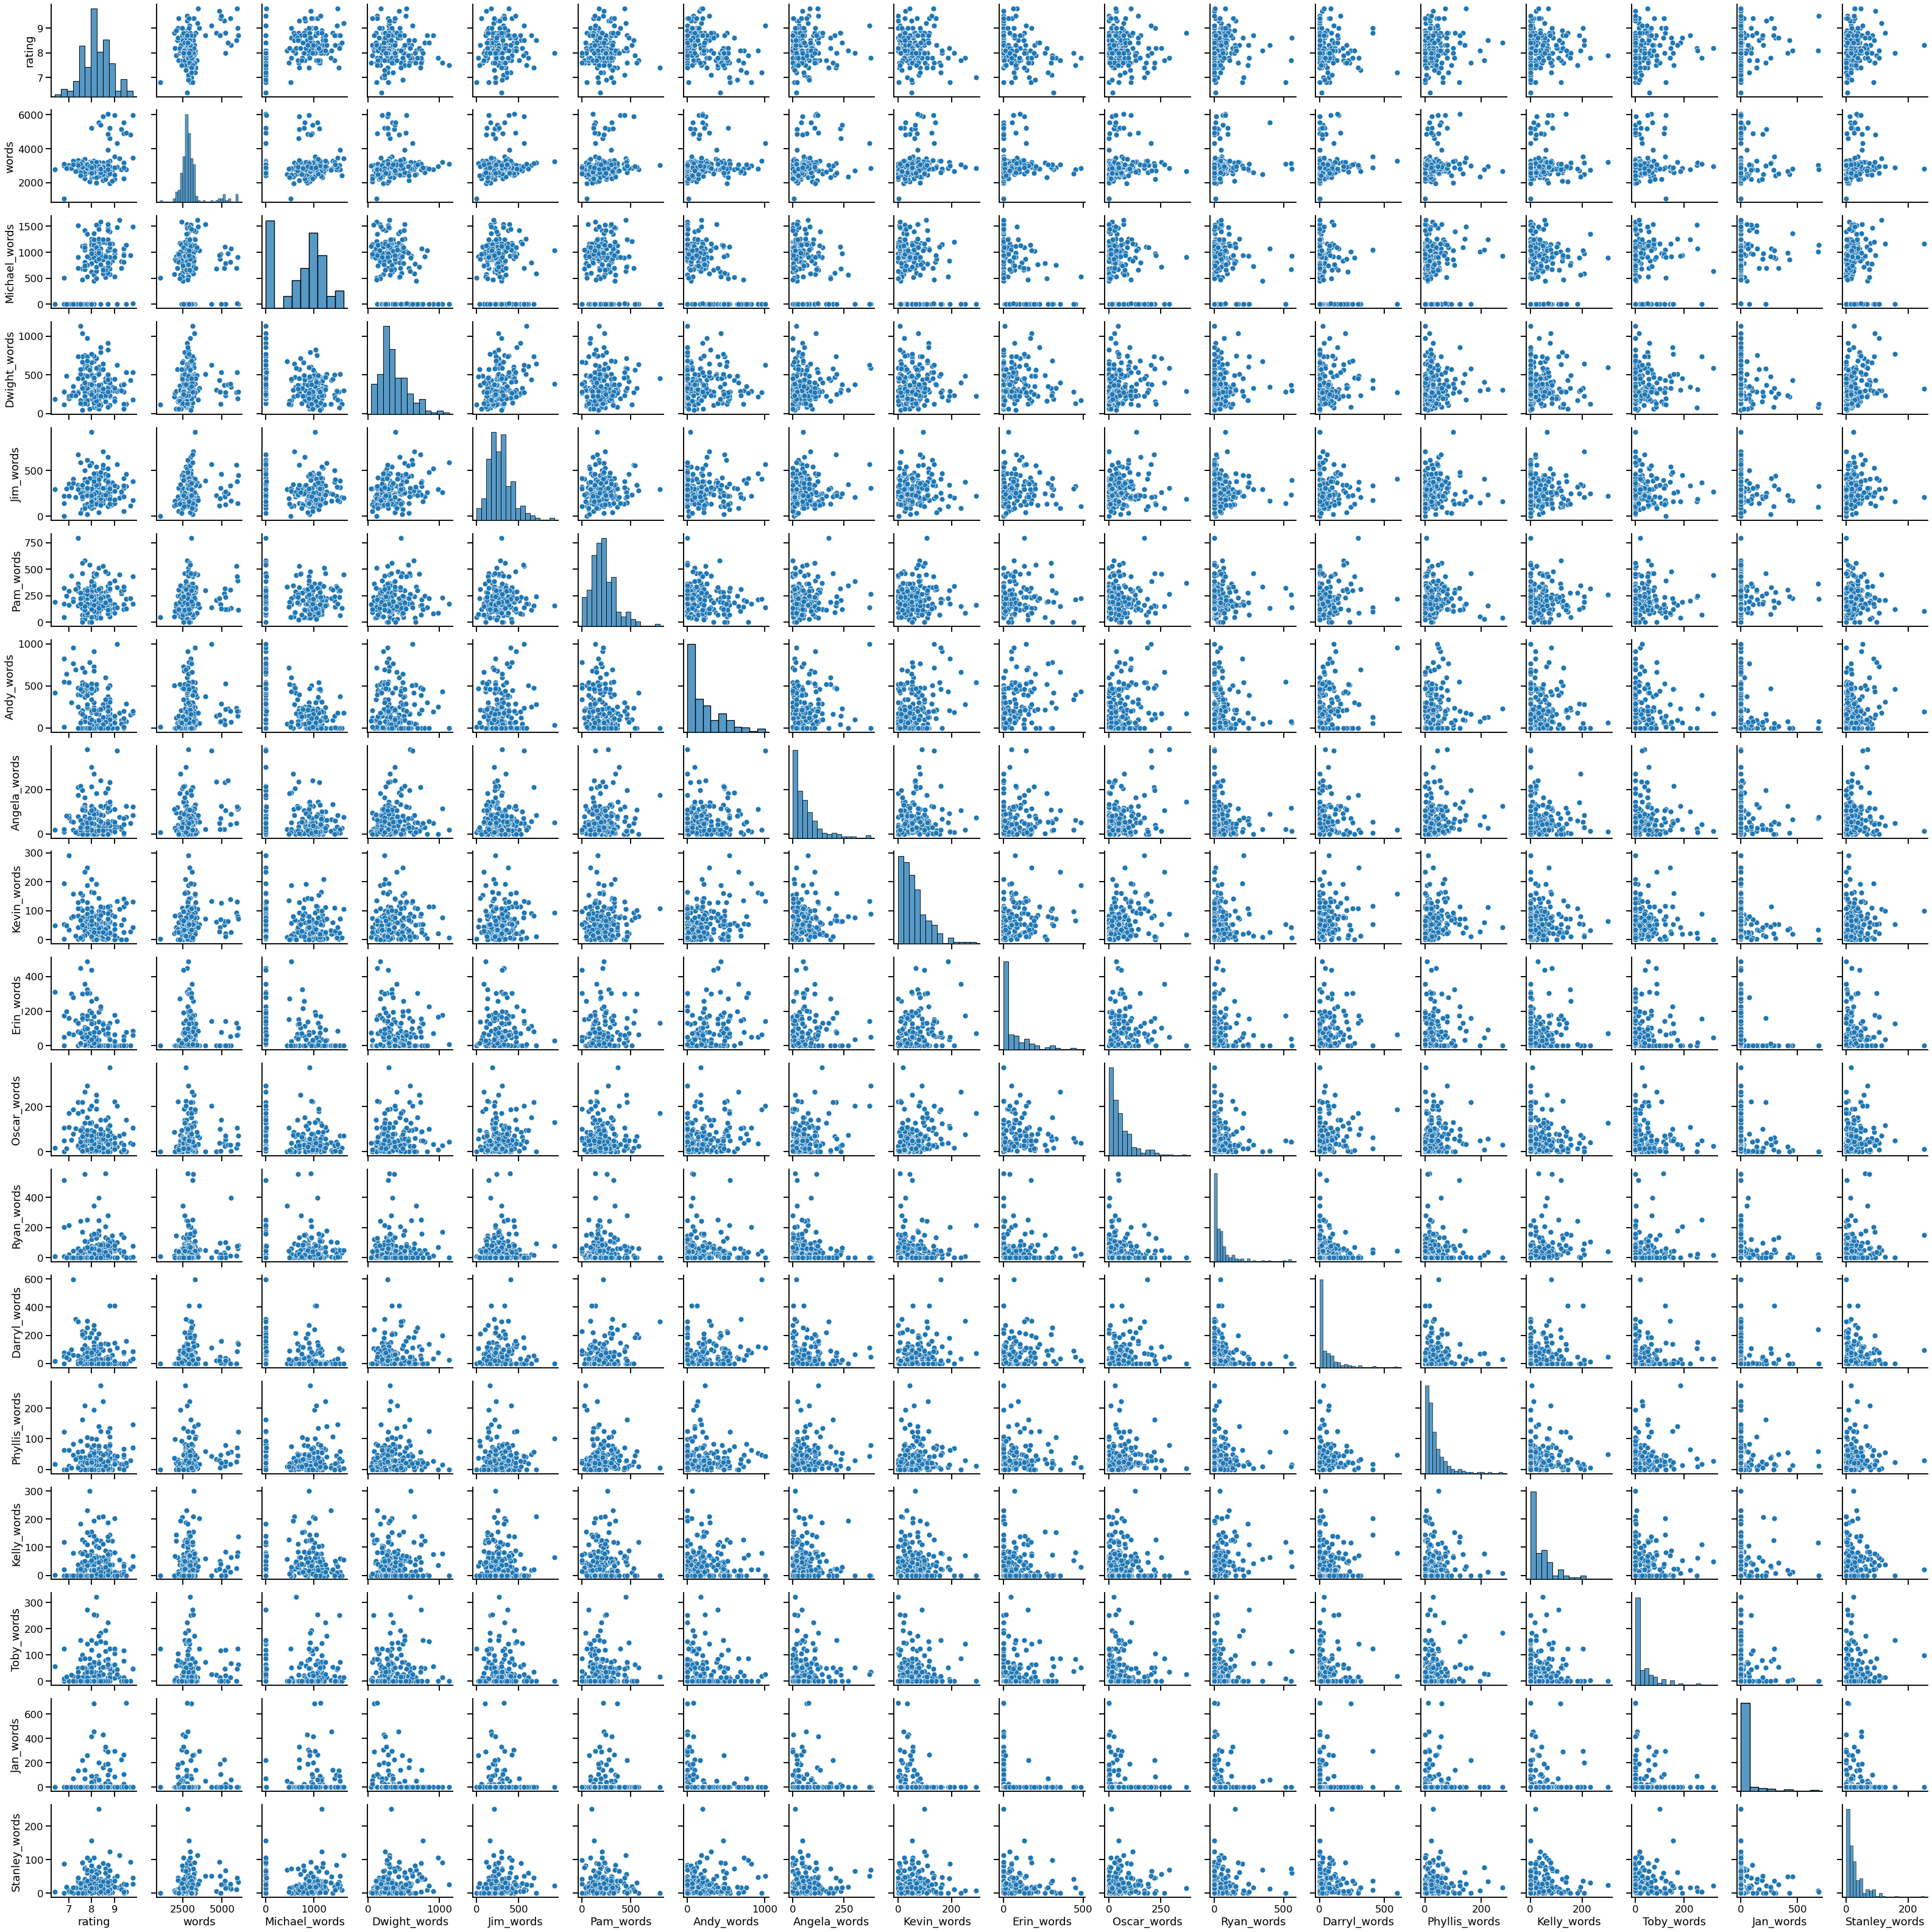

In [128]:
sns.set_context('talk',font_scale=1)
sns.pairplot(df.drop(columns=['season','title','votes','double','episode','month','director','writer'], axis=1))

# Character name appearance

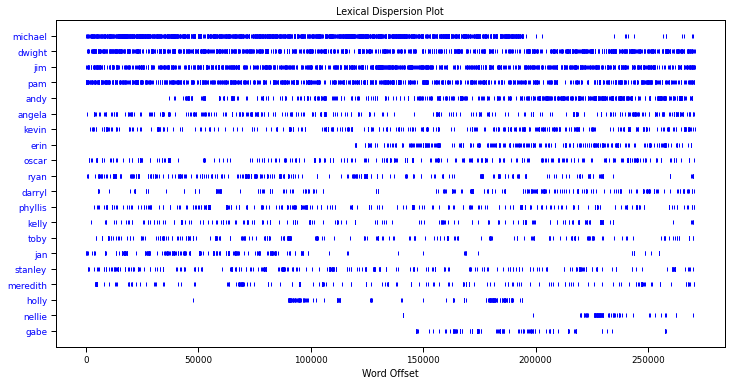

In [142]:
plt.figure(figsize=(12,6))
dispersion_plot(all_text_without_stop,['michael', 'dwight', 'jim', 'pam', 'andy', 'angela', 'kevin', 'erin',
       'oscar', 'ryan', 'darryl', 'phyllis', 'kelly', 'toby', 'jan', 'stanley',
       'meredith', 'holly', 'nellie', 'gabe'],ignore_case=True)

# count the phrase
'she said', 'michael, no'

In [81]:
text = prepare_text(text_row,stop=False)
text_stopped = prepare_text(text_row)

In [74]:
tt = nltk.FreqDist(text).most_common(10)
tt

[('yeah', 30),
 ('know', 20),
 ('right', 18),
 ('pam', 18),
 ('going', 17),
 ('ok', 14),
 ('think', 14),
 ('oh', 13),
 ('go', 12),
 ('downsizing', 12)]

In [76]:
for t in tt:
    print(t[0])

yeah
know
right
pam
going
ok
think
oh
go
downsizing


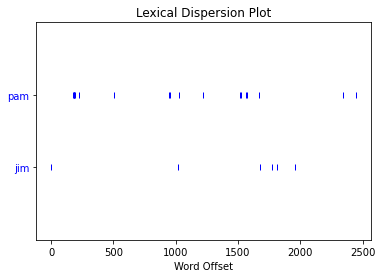

In [33]:
dispersion_plot(text,['pam','jim'],ignore_case=True)

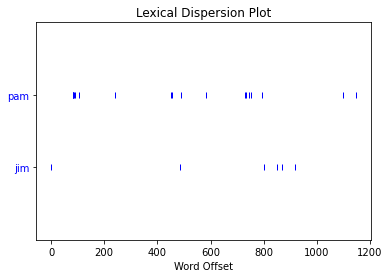

In [35]:
dispersion_plot(text_stopped,['pam','jim'],ignore_case=True)